In [1]:
from xraycam.nbinit import *
camcontrol.set_detector('zwo')
from xraycam.camalysis import *
from xraycam.camcontrol import Monitor

Process Process-2:
Traceback (most recent call last):
  File "/home/xrays/.local/lib/python3.5/site-packages/multiprocess-0.70.4-py3.5.egg/multiprocess/process.py", line 254, in _bootstrap
    self.run()
  File "/home/xrays/.local/lib/python3.5/site-packages/multiprocess-0.70.4-py3.5.egg/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xrays/.local/lib/python3.5/site-packages/xraycam-0.0.0-py3.5.egg/xraycam/zwo.py", line 85, in sink_process
    zmq_comm.start_sink_routine(sink_function)
  File "/home/xrays/.local/lib/python3.5/site-packages/xraycam-0.0.0-py3.5.egg/xraycam/zmq_comm.py", line 82, in start_sink_routine
    receiver.bind(sink_addr)
  File "zmq/backend/cython/socket.pyx", line 495, in zmq.backend.cython.socket.Socket.bind (zmq/backend/cython/socket.c:5327)
  File "zmq/backend/cython/checkrc.pxd", line 25, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/socket.c:9542)
zmq.error.ZMQError: Address already in use


# Working on parabolic binning finesse

In [2]:
znsz0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '10.17.znsz0', htime='10m')

Loaded from cache.


In [3]:
znsz2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '10.17.znsz2')

Loaded from cache.


In [4]:
def get_peaks(lineout,interp=True,**kwargs):
    """Get location of peaks using PeakUtils package.
    Format should be lineout=[energies,intensities].
    Returns [peaks_x,peaks_y].
    Peaks_x location is optionally improved using interpolation.
    Interpolation is hard-coded for Gaussian.  Can be modified for centroid, others."""
    
    #Import peak-detection package if not already loaded.
    import peakutils
    
    #Get thres and min_dist for peak-detection, set default if not provided
    thres = kwargs.get('thres',0.75)
    min_dist = kwargs.get('min_dist',30)
    width = kwargs.get('width',10)
    
    #Find peak indices
    x, y = lineout
    indexes = peakutils.indexes(y,thres=thres,min_dist=min_dist)
    peaks_x, peaks_y = lineout[0][indexes], lineout[1][indexes]
    
    #Improve peak location by fitting function locally around detected peaks in the data.  Default is gaussian.
    if interp:
        peaks_x=[]
        peaks_y=[]
        for i in indexes:
            a,b,c = peakutils.peak.gaussian_fit(x[int(i-width):int(i+width)],y[int(i-width):int(i+width)],center_only=False)
            peaks_x.append(b)
            peaks_y.append(a)

    return np.array([peaks_x,peaks_y])

In [216]:
class ParabolicFit:
    
    def __init__(self,datarun,**kwargs):
        try:
            self.run = datarun.run
        except AttributeError:
            self.run = datarun
            
        self.raw_array = self.run.get_frame().data
        self.raw_lineout = self.run.get_frame().get_lineout(energy=(2307,None))
        self.peaks = get_peaks(self.raw_lineout)
        #TODO: change fwhm_ev function to put out float instead of str
        self.fwhm = float(fwhm_ev(self.raw_lineout))
        self.erange = self.raw_lineout[0][-1]-self.raw_lineout[0][0]
        self.fitparameters = quadfit(self.raw_array)
        self.fitregion = {'xrange':[0,-1], 'yrange':[0,-1]}
        self.set_fitregion()
        self.update_quadfit()
        
    def cm_plot(self,smooth=5,show=True):
        xrange, yrange = self.fitregion['xrange'], self.fitregion['yrange']
        y = gfilt(center_of_masses(self.raw_array[yrange[0]:yrange[1],xrange[0]:xrange[1]]),smooth)
        x = np.arange(len(y))
        plt.plot(x+yrange[0],y+xrange[0],label="CM")
        if yrange == [0,-1]: 
            length = 1936 
        else: 
            length = yrange[1]-yrange[0]
        #length=1936
        
        plt.plot(*self.generate_parabola(),label="parab")
        if show:
            plt.show()
        return np.array([x,y])
            
    def calc_vertex(self):
        a, b, c = self.fitparameters
        vertexx = -b/(2*a)
        vertexy = a*vertexx**2+b*vertexx+c
        return (vertexx,vertexy)
    
    def generate_parabola(self,length=1936):
        a, b, c = self.fitparameters
        x = np.arange(length)
        y = a*x**2+b*x+c
        #if self.fitregion['xrange'] != [0,1]:
        #    y+=self.fitregion['xrange'][0]
        return np.array([x,y])
    
    def update_quadfit(self):
        xrange, yrange = self.fitregion['xrange'], self.fitregion['yrange']
        a, b, c = quadfit(self.raw_array[yrange[0]:yrange[1],xrange[0]:xrange[1]])
        #b = b-2*a*yrange[0]
        #c = a*yrange[0]**2-b*yrange[0]+c+xrange[0]
        vx = -b/(2*a)
        vy = (4*a*c-b**2)/(4*a)
        vx+=yrange[0]
        vy+=xrange[0]
        b = -2*a*vx
        c = vy+a*vx**2
        self.fitparameters = (a, b, c)
        
    def set_fitregion(self,width=0.2,region=None):
        if region:
            xrange=region
        else:
            xupper = np.searchsorted(self.raw_lineout[0],self.peaks[0,0]+self.erange*width/2)
            xlower = np.searchsorted(self.raw_lineout[0],self.peaks[0,0]-self.erange*width/2)
            self.fitregion['xrange'] = [xlower,xupper]
    
    def parabolic_sort(self,shape = (1936, 1096),xrange=[0,-1],yrange=[0,-1]):
        """
        Returns: z, (rowsort, colsort)

        z : 2d numpy array of shape `shape` with values x**2 + b * x + c,
        where x is row index.
        rowsort : sequence of row indices that sort z
        colsort : sequence of column indices that sort z
        """
        a, b, c = self.fitparameters
        x, y = np.indices(shape, dtype = 'int')
        z = -((a * (x**2)) + (b * x) - y)
        z = z[yrange[0]:yrange[1],xrange[0]:xrange[1]]
        return z, np.unravel_index(
                    np.argsort(z.ravel()), z.shape)
            
    def parabolic_lineout(self, energy=(None,None), nbins = None, xrange=[0,-1],yrange=[0,-1]):
        """Return lineout taken using parabolic bins"""
        arr2d = self.raw_array[yrange[0]:yrange[1],xrange[0]:xrange[1]]
        num_rows, num_cols = arr2d.shape
        if nbins is None:
            nbins = num_cols
        def chunks():
            """Return array values grouped into chunks, one per bin"""
            increment = int(num_rows * (num_cols/nbins))
            _, sort_indices = self.parabolic_sort(xrange=xrange,yrange=yrange)
            sort_data = arr2d[sort_indices].ravel()
            return [sort_data[i:i + increment] for i in range(0, len(sort_data), increment)]
        lineouty = np.array(list(map(np.sum, chunks())))/self.run.photon_value
        if energy == (None,None):
            lineoutx = np.arange(len(lineouty))
            lineout = np.array([lineoutx,lineouty])
        else:
            lineout = add_energy_scale(lineouty,energy[0],known_bin=energy[1])
        return lineout
    
    def check_fit(self,xrange=[0,-1],yrange=[0,-1]):
        from scipy import stats
        arr2d = self.raw_array[yrange[0]:yrange[1],xrange[0]:xrange[1]]
        z, _ = self.parabolic_sort(xrange=xrange,yrange=yrange)
        
        parr = np.sum([stats.threshold(z,threshmin=i,threshmax=i+5,newval=0) for i in range(100,1000,40)],axis=0)
        parr[parr>0]=500
        plt.imshow(parr+arr2d)
        plt.show()
        
            
        
    

In [217]:
pf2=ParabolicFit(znsz2)

In [229]:
pf2.fitregion['yrange']=[500,1500]

In [230]:
pf2.fitregion

{'xrange': [329, 550], 'yrange': [500, 1500]}

In [232]:
pf2.calc_vertex()

(416.86979830008914, 440.42394202666526)

In [233]:
pf2.fitparameters

(-1.387050168232662e-05, 0.01156438647726509, 438.01352029754435)

In [231]:
pf2.update_quadfit()

In [234]:
_ = pf2.cm_plot()

In [138]:
xrange, yrange = pf2.fitregion['xrange'], pf2.fitregion['yrange']
a, b, c = quadfit(pf2.raw_array[yrange[0]:yrange[1],xrange[0]:xrange[1]])

In [198]:
(a,b,c)

(-1.6105888129396715e-05, -0.0041200185277765955, 166.80729371112525)

In [179]:
x,y = np.indices((2000,1000))

In [193]:
z=-a*x**2-b*x+y

In [166]:
parr

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [152]:
from scipy import stats

In [175]:
parr = np.sum([stats.threshold(z,threshmin=i,threshmax=i+5,newval=0) for i in range(100,1000,40)],axis=0)

In [159]:
import matplotlib.pyplot as mplt

<IPython.core.display.Javascript object>


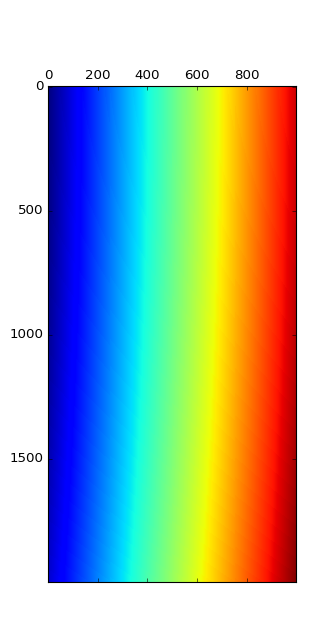

In [194]:
mplt.matshow(z)
mplt.show()

<IPython.core.display.Javascript object>


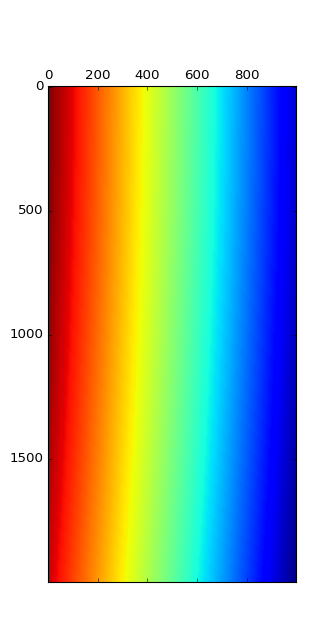

In [192]:
mplt.matshow(z)
mplt.show()

In [1]:
pf2.check_fit(yrange=[500,1500])

NameError: name 'pf2' is not defined

In [72]:
znscompare = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'zns0.contd.9.15')

Loaded from cache.


In [73]:
def normalize_lineout(lineout):
    lx, ly = lineout
    ly = ly/max(ly)
    return np.array([lx,ly])

In [237]:
plt.plot(*normalize_lineout(pf2.parabolic_lineout(energy=(2307,None),yrange=[900,1150])),label='para')
znsz2.run.plot_lineout(energy=(2307,None),yrange=[900,1150], peaknormalize=True,show=False)
znscompare.run.plot_lineout(energy=(2307,None),yrange=[536,936],rebin=1,show=False, peaknormalize=True)
plt.show()

In [307]:
pf.raw_array.T.shape

(1096, 1936)

In [357]:
pf = ParabolicFit(znsz0)

<IPython.core.display.Javascript object>


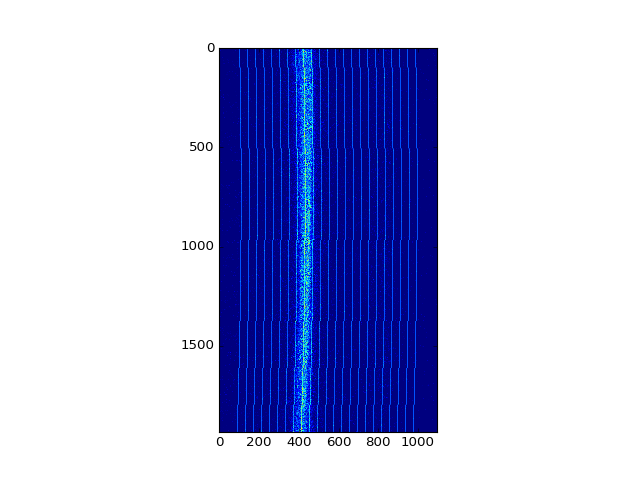

In [358]:
pf.check_fit()

<IPython.core.display.Javascript object>


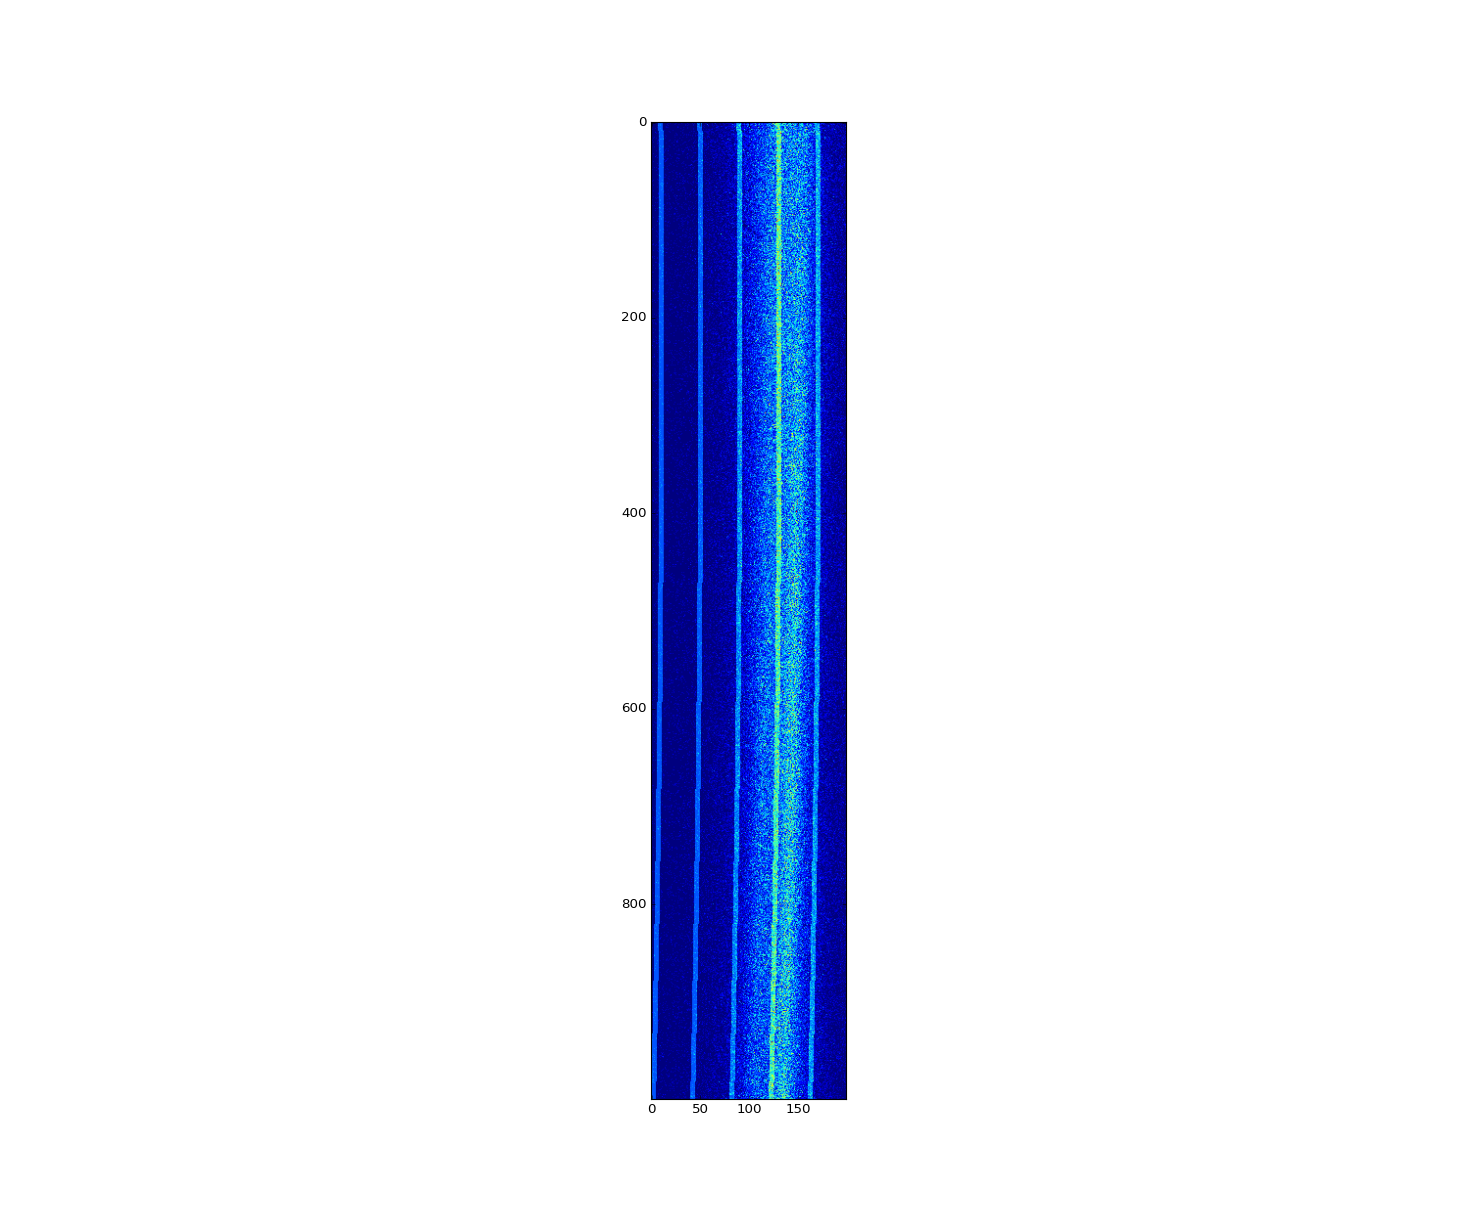

In [354]:
pf.check_fit(xrange=[300,500],yrange=[500,1500])

In [356]:
plt.plot(*pf.parabolic_lineout(energy=(2307,None),yrange=[0,-1]),label='parab')
znsz0.run.plot_lineout(energy=(2307,None),yrange=[0,-1],show=False)
plt.show()

<IPython.core.display.Javascript object>


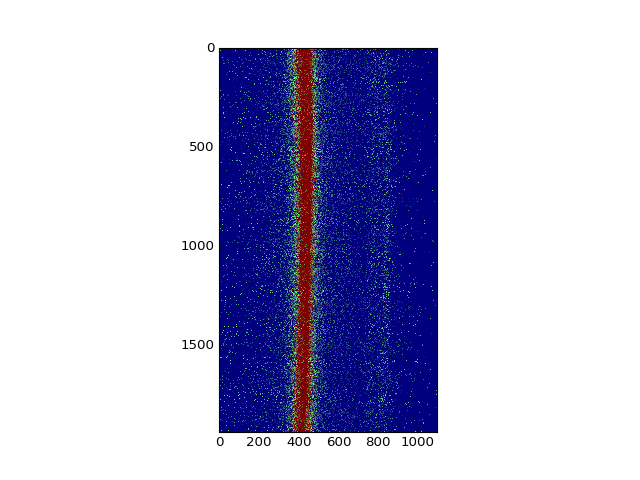

In [162]:
znsz0.run.show(vmax=250)

In [359]:
pf.cm_plot()

array([[  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          1.93200000e+03,   1.93300000e+03,   1.93400000e+03],
       [  1.54872607e+02,   1.54865908e+02,   1.54855887e+02, ...,
          1.47792108e+02,   1.47844187e+02,   1.47871139e+02]])